# Create Multi Needle In A Haystack Visualization

Let's run through how to create the visualization for the Multi Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Read your results (e.g., from LangSmith dataset or local)
2. Plot your % retrieved with respect to contet length (as done in Gemini 1.5 [paper](https://storage.googleapis.com/deepmind-media/gemini/gemini_v1_5_report.pdf))
4. Optionally plot retrieval with respect to position for each needle

## Get results from eval sets

`eval_sets_retrieval`

* https://smith.langchain.com/public/af0f1c89-3993-4ded-91c2-29eebef67582/d
* https://smith.langchain.com/public/d6b47e6e-8279-4452-bd22-d6c8b839f1a0/d
* https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d

`eval_sets_reasoning`

* https://smith.langchain.com/public/a85db85f-ee45-4a39-a1ac-52f7279134ac/d
* https://smith.langchain.com/public/270cd9cd-154d-4ba9-8b34-7b6537007867/d
* https://smith.langchain.com/public/00658b64-6199-48fc-9443-1478aadbe19a/d

In [35]:
# Eval set name for LangSmith
eval_sets_retrieval = ["multi-needle-eval-pizza-1",
                       "multi-needle-eval-pizza-3",
                       "multi-needle-eval-pizza-10"]

eval_sets_reasoning = ["multi-needle-eval-pizza-reasoning-1",
                       "multi-needle-eval-pizza-reasoning-3",
                       "multi-needle-eval-pizza-reasoning-10"]

In [ ]:
import pandas as pd 
from langsmith.client import Client

# Get all runs for a given eval set
client = Client()

def get_data(eval_sets,model):

    # Store
    all_data = []
    
    # Iterate through eval sets 
    for set in eval_sets:

        print(f"Getting data for eval set: {set}")
    
        # All projects in a given eval set
        projects = client.list_projects(reference_dataset_name=set)
        
        # Iterate through the projects
        for p in projects:

            # Each project performs evaluation on all questions
            project = client.read_project(project_name=p.name)

            # Check that full logging is present and model 
            if 'needles' in project.metadata and project.metadata['model_name'] == model:

                # Get each question evaluation in our eval set
                runs = list(client.list_runs(project_id=project.id, execution_order=1))

                print(f"Getting data for run: {p.name}")

                # Get url 
                if client.run_is_shared(run_id=runs[0].id):
                    url = client.read_run_shared_link(runs[0].id)    
                else:
                    url = client.share_run(run_id=runs[0].id)   

                # Our eval set only has 1 question, so we extract it
                trace = client.get_test_results(project_name=p.name)

                # Get answer 
                generation = trace.loc[0,'outputs.output.content']
                
                # Get project metadata
                data = {
                    'run_name': project.name,
                    'run_url': url,
                    'depth %': project.metadata['depth_percent'],
                    'context length': project.metadata['context_length'],
                    'retrieved needles': project.feedback_stats['needles_retrieved']['avg'],
                    'model name': project.metadata['model_name'],
                    'total needles': project.metadata['num_needles'],
                    'answer': generation,
                    'needles': project.metadata['needles'],
                    'insertion_percentages': project.metadata['insertion_percentages']
                }
                
                # Add the data dictionary to the list
                all_data.append(data)
            
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)
    df.set_index("run_name",inplace=True)
    df['percent'] = df['retrieved needles'] / df['total needles'] 
    return df

df_gpt4 = get_data(eval_sets_retrieval,"gpt-4-0125-preview")
df_anthropic = get_data(eval_sets_retrieval,"claude-3-opus-20240229")

In [49]:
df_gpt4.to_csv("gpt4vClaude_expt_df_gpt4.csv")
df_anthropic.to_csv("gpt4vClaude_expt_df_anthropic.csv")

In [54]:
df_gpt4=pd.read_csv("gpt4vClaude_expt_df_gpt4.csv")
df_anthropic=pd.read_csv("gpt4vClaude_expt_df_anthropic.csv")

## Aggregate

Aggregate replicates for each combination of `total needles`, `model name`, `context length`

In [55]:
def group(df):
    
    agg_df = df.groupby(['total needles', 'model name', 'context length']).agg(
        mean=('retrieved needles', lambda x: x.sum() / df.loc[x.index, 'total needles'].sum()), 
        mean_percent=('percent', 'mean'), 
        urls=('run_url', lambda x: list(x)[:3])).reset_index()
    return agg_df

agg_df_gpt4 = group(df_gpt4)
agg_df_anthropic = group(df_anthropic)

## Plot % needles retrieved wrt context length

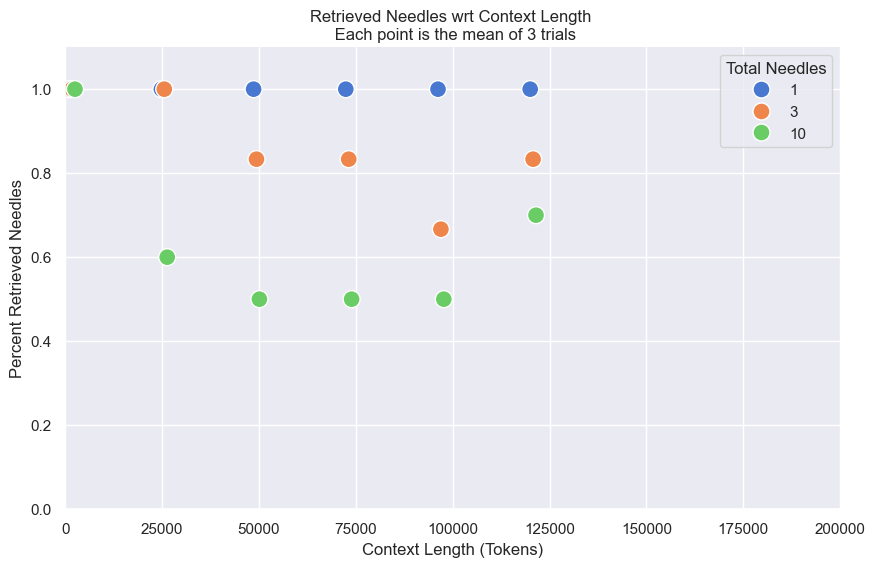

In [56]:
def plot(df,model,plot_col):

    # Setting the theme
    sns.set_theme(style="darkgrid" )

    # Select a model
    df = df[df["model name"]==model].copy()

    # Function to add fixed offset based on 'total needles'
    def add_fixed_offset(series, base_offset):
        # Apply fixed offset
        offset_series = series.apply(lambda x: x * base_offset)
        return offset_series
    
    # Calculate a fixed offset for 'context length' based on 'total needles'
    base_offset = 1500  # Base offset value, adjust based on your visual and data needs
    df['context length offset'] = add_fixed_offset(df['total needles'], base_offset)

    # Sort and map 'total needles' to a fixed offset based on order
    unique_needles_sorted = sorted(df['total needles'].unique())
    offset_map = {val: i * 750 for i, val in enumerate(unique_needles_sorted)}  # 750 is the base offset
    
    # Apply the fixed offset based on 'total needles' order
    df['context length offset'] = df['total needles'].map(offset_map)
    
    # Adjust 'context length' to include the calculated offset
    df['context length jittered'] = df['context length'] + df['context length offset']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, 
                    x="context length jittered", 
                    y=plot_col, 
                    hue="total needles", 
                    palette=sns.color_palette("muted", 3),
                    s=150,
                    edgecolor='white', 
                    linewidth=1)  # Added edgecolor and linewidth for outline
    sns.despine()
    
    # Adding labels and title for clarity
    plt.xlabel("Context Length (Tokens)")
    plt.ylabel("Percent Retrieved Needles")
    plt.title("Retrieved Needles wrt Context Length \n Each point is the mean of 3 trials")
    plt.legend(title='Total Needles')
    
    # Display the plot
    plt.xlim([-50,200000])
    plt.ylim([0,1.1])
    plt.show()

    return df

d = plot(agg_df_gpt4,"gpt-4-0125-preview","mean_percent")

## Plot retrieval wrt position 

In [69]:
def prepare_for_scatterplot(df):

    # Collect the results from all rows in df_model
    all_results = []
    
    # Iterate over each row in df_model
    for index, row in df.iterrows():
        
        needle_texts = row['needles']
        
        # Extracting just the ingredient names from each sentence in "needle text"
        needle_points = [sentence.strip().strip().replace(" is one of the secret ingredients needed to build the perfect pizza.", "").replace(" are the secret ingredient needed to build the perfect pizza.", "").replace(" are one of the secret ingredients needed to build the perfect pizza.", "") for sentence in needle_texts]
        
        # Get the "answer" from the row in "df_model"
        llm_answer = row['answer'] 
        
        # Check which needle points are in the answer
        context_size = row['context length']
        run_name = row['run_url']  
        total_needles = row['total needles']  
        run_url = row['run_url']  
        insertion_percentages = row['insertion_percentages']
        
        for needle, insertion_percent in zip(needle_points, insertion_percentages):
            present = 1 if needle.lower() in llm_answer.lower() else 0
            all_results.append({
                'needle': needle,
                'needle point': needle,
                'insertion %': insertion_percent,
                'context size': context_size,
                'present in the answer': present,
                'total_needles':total_needles,
                'run name': run_name,
                'run_url': run_url
            })
    
    return pd.DataFrame(all_results)

results_df_gpt4 = prepare_for_scatterplot(df_gpt4)
results_df_anthropic = prepare_for_scatterplot(df_anthropic)

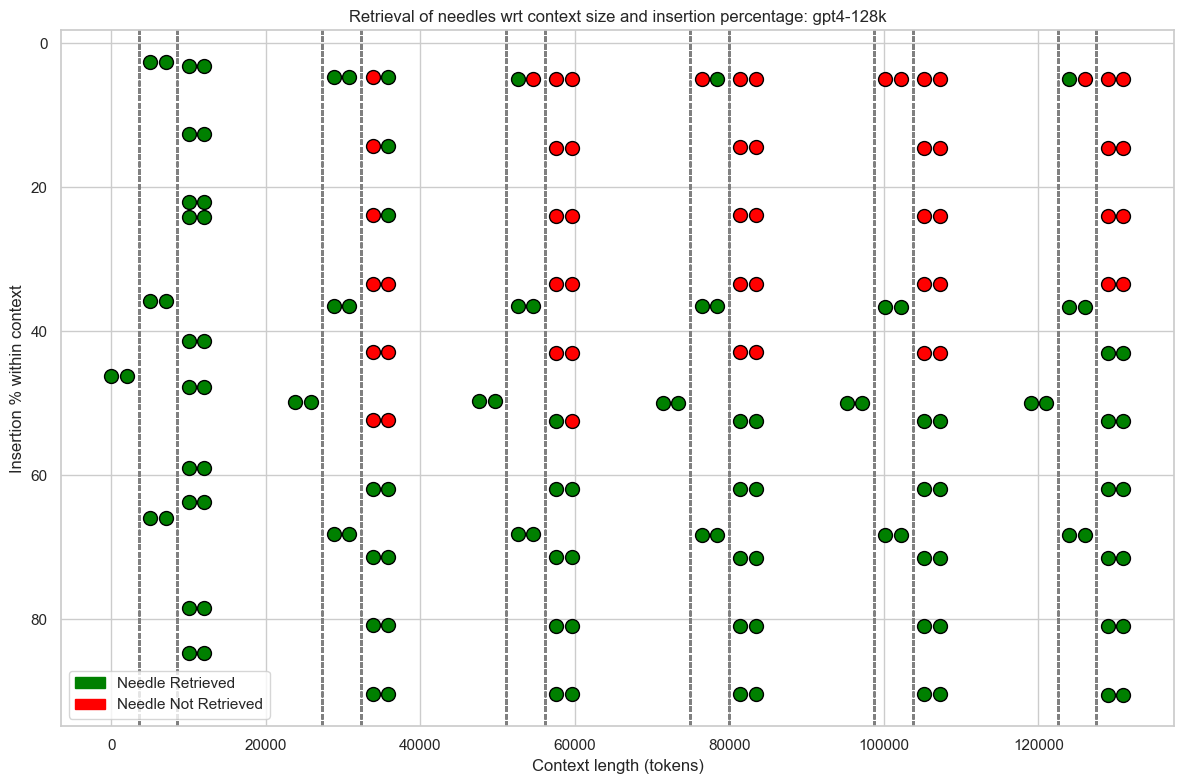

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plt_multi_needle_scatter(results_df, model):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    context_sizes = sorted(results_df['context size'].unique())
    total_needles_values = sorted(results_df['total_needles'].unique())
    
    group_base_offset = 5000
    point_size = 100
    edge_color = 'black'

    for context_size in context_sizes:
        for j, total_needles in enumerate(total_needles_values):
            # Adjusted to include a check for unique 'insertion %' values within the subset
            unique_insertion_percentages = sorted(results_df[results_df['context size'] == context_size]['insertion %'].unique())
            
            for insertion_percentage in unique_insertion_percentages:
                subset = results_df[(results_df['context size'] == context_size) & (results_df['total_needles'] == total_needles) & (results_df['insertion %'] == insertion_percentage)]
                
                if not subset.empty:
                    if len(subset) > 1:
                        dynamic_offsets_within_group = np.linspace(-1000, 1000, num=len(subset))
                    else:
                        dynamic_offsets_within_group = [0]  # No offset if there's only one replicate
                    
                    for k, (index, row) in enumerate(subset.iterrows()):
                        color = 'green' if row['present in the answer'] == 1 else 'red'
                        final_offset = (j * group_base_offset) + dynamic_offsets_within_group[k]
                        plt.scatter(context_size + final_offset, row['insertion %'], s=point_size, color=color, edgecolor=edge_color, linewidth=1)

                for i in range(1, len(total_needles_values)):
                    line_position = context_size + (i * group_base_offset) - (group_base_offset / 2)
                    plt.axvline(x=line_position, color='grey', linestyle='--', linewidth=1)

    plt.xlabel("Context length (tokens)")
    plt.ylabel("Insertion % within context")
    plt.title(f"Retrieval of needles wrt context size and insertion percentage: {model}")
    plt.gca().invert_yaxis()
    green_patch = mpatches.Patch(color='green', label='Needle Retrieved')
    red_patch = mpatches.Patch(color='red', label='Needle Not Retrieved')
    plt.legend(handles=[green_patch, red_patch], loc='lower left')
    plt.tight_layout()
    plt.savefig(f"plot_needle_retrieval_{model}.png", dpi=300, bbox_inches='tight')
    plt.show()

plt_multi_needle_scatter(results_df_gpt4,"gpt4-128k")

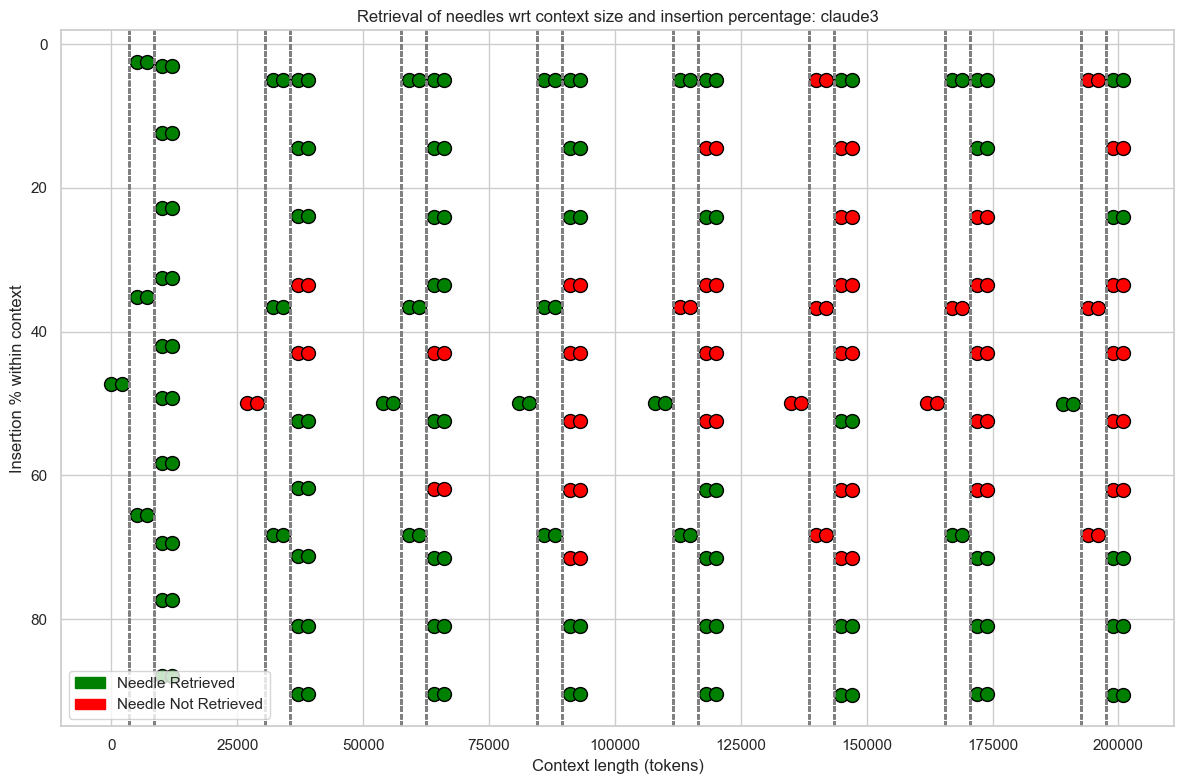

In [72]:
plt_multi_needle_scatter(results_df_anthropic,"claude3")